In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [42]:
dataset = pd.read_csv('ratings.csv')
dataset['movieId'].nunique()

9066

In [43]:
dataset.head(4)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185


In [44]:
sparsity = dataset.shape[0]/(dataset['movieId'].nunique() * dataset['userId'].nunique())

In [45]:
print(sparsity)

0.016439141608663475


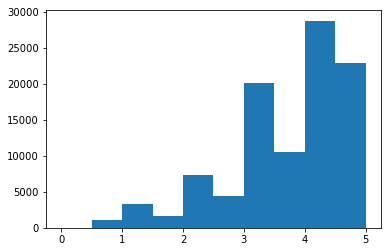

In [46]:
plt.hist(dataset['rating'],bins=np.arange(0, 5 + 0.5, 0.5))
plt.show()

In [47]:
from collections import Counter
movie_ids = dataset['movieId']
#Counter(movie_ids)

In [48]:
movie_ratings_dict = dict(Counter(movie_ids))

In [49]:
plt.plot(range(0,len(movie_ratings_dict.keys())), sorted(movie_ratings_dict.values(),reverse=True))

In [50]:
user_ids = dataset['userId']

In [51]:
user_ratings_dict = dict(Counter(user_ids))

In [52]:
plt.plot(range(0,len(user_ratings_dict.keys())), sorted(user_ratings_dict.values(),reverse=True))

In [53]:
sum(sorted(user_ratings_dict.values(),reverse=True)[:100])

55141

In [54]:
id_var = (dataset[['movieId','rating']].groupby('movieId',as_index=False)).var().fillna(0)


In [55]:
id_var_dict = dict(zip(list(id_var['movieId']), id_var['rating']))


In [56]:
var_list = list(dataset[['movieId','rating']].groupby('movieId').var()['rating'])

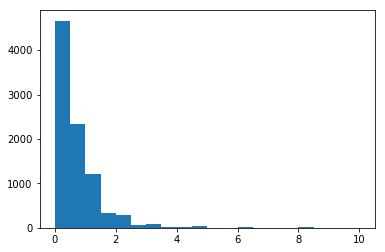

In [58]:
plt.hist(np.nan_to_num(var_list),bins=np.arange(min(var_list), max(var_list), 0.5))
plt.show()

In [59]:
def get_popular(movie_ratings_dict, testset):
    movieids = [x[0] for x in movie_ratings_dict.items() if x[1]>2]
    return [x for x in testset if x[1] in movie_ids]
def get_unpopular(movie_ratings_dict, testset):
    movieids = [x[0] for x in movie_ratings_dict.items() if x[1]<=2]
    return [x for x in testset if x[1] in movie_ids]

def get_highvar(movie_ratings_dict, var_dict, testset):
    movieids = [x[0] for x in movie_ratings_dict.items() if x[1]>=5]
    movieids = [x for x in high_variance_movieids if var_dict[x]>=2 ]
    return [x for x in testset if x[1] in movie_ids]
    

### Question 10 - 14

#### Takes 15-20 min

In [60]:
from surprise import SVD

In [61]:
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise import Dataset
from surprise import accuracy
from surprise import Reader


In [62]:
def do_kFold(data_, range_,trimm,movie_ratings_dict,splits=10, id_var_dict=None):
    sim_options = {'name': 'pearson_baseline'}
    kf = KFold(n_splits=splits)
    reader = Reader(rating_scale=(1, 5))
    mae_d={}
    rmse_d={}
    for neigh in range_:
        print('Neighbors ',neigh)
        knn_model = KNNWithMeans( k=neigh, sim_options= sim_options)
        rmse_list=[]
        mae_list =[]
        for trainset, testset in kf.split(data_):
            #print(testset)
            if(trimm=='p'):
                testset = get_popular(movie_ratings_dict,testset)
            elif(trimm=='up'):
                testset = get_unpopular(movie_ratings_dict,testset)
            elif(trimm=='hv'):
                testset = get_highvar(movie_ratings_dict,testset)
            knn_model.fit(trainset)
            predictions = knn_model.test(testset,verbose=False)
            rmse_list.append(accuracy.rmse(predictions,verbose=False))
            mae_list.append(accuracy.mae(predictions,verbose=False))
        rmse_d[neigh]=sum(rmse_list)/len(rmse_list)
        mae_d[neigh]=sum(mae_list)/len(mae_list)
        print('Mean rmse',sum(rmse_list)/len(rmse_list))
        print('Mean mae',sum(mae_list)/len(mae_list))
    return rmse_d, mae_d



In [63]:
def rmse_mae_plot(rmse_d,mae_d):
    plt.plot(rmse_d.keys(),rmse_d.values())
    plt.show()
    plt.plot(mae_d.keys(),mae_d.values())
    plt.show()

In [167]:
total_data = Dataset.load_from_df(dataset[['userId','movieId','rating']], reader)
r_d,m_d = do_kFold(total_data, range(2,101,20),'notrim',movie_ratings_dict)#TODO use 2 instead of 8. 8 is used to compute faster

Neighbors  2
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearso

In [ ]:
rmse_mae_plot(r_d,m_d)

### Question 11

 k value =20


 RMSE = 0.9146735

### Question 12,13,14

In [ ]:
rp_d, mp_d = do_kFold(total_data, range(2,101,20),'p',movie_ratings_dict)#TODO use 2 instead of 8. 8 is used to compute faster
rup_d,mup_d =do_kFold(total_data, range(2,101,20),'up',movie_ratings_dict)#TODO use 2 instead of 8. 8 is used to compute faster
rhv_d,mhv_d =do_kFold(total_data, range(2,101,20),'hv',movie_ratings_dict, id_var_dict)#TODO use 2 instead of 8. 8 is used to compute faster

### TODO : Run and plot

### NMF Filtering

#### Questions 17-21

In [ ]:
from surprise.prediction_algorithms.matrix_factorization import NMF

In [64]:
def NMF_filter(data_, range_,trimm,movie_ratings_dict,splits=10, id_var_dict=None):
    kf = KFold(n_splits=splits)
    reader = Reader(rating_scale=(1, 5))
    mae_d={}
    rmse_d={}
    for latent_factors in range_:
        print('Number of Latent Factors : ',latent_factors)
        nmf_model = NMF(n_factors = latent_factors)
        rmse_list=[]
        mae_list =[]
        for trainset, testset in kf.split(data_):
            #print(testset)
            if(trimm=='p'):
                testset = get_popular(movie_ratings_dict,testset)
            elif(trimm=='up'):
                testset = get_unpopular(movie_ratings_dict,testset)
            elif(trimm=='hv'):
                testset = get_highvar(movie_ratings_dict,testset)
            nmf_model.fit(trainset)
            predictions = nmf_model.test(testset,verbose=False)
            rmse_list.append(accuracy.rmse(predictions,verbose=False))
            mae_list.append(accuracy.mae(predictions,verbose=False))
        rmse_d[latent_factors]=sum(rmse_list)/len(rmse_list)
        mae_d[latent_factors]=sum(mae_list)/len(mae_list)
        print('Mean rmse',sum(rmse_list)/len(rmse_list))
        print('Mean mae',sum(mae_list)/len(mae_list))
    return rmse_d, mae_d


In [65]:
total_data = Dataset.load_from_df(dataset[['userId','movieId','rating']], reader)
nmf_rmse , nmf_mae = NMF_filter(total_data, range(2,51,8),'notrim',movie_ratings_dict) #replace 8 with 2

Number of Latent Factors :  2
Mean rmse 1.1745299532
Mean mae 0.99413601042
Number of Latent Factors :  10
Mean rmse 0.955925025689
Mean mae 0.748620176982
Number of Latent Factors :  18
Mean rmse 0.938859732656
Mean mae 0.716481420556
Number of Latent Factors :  26
Mean rmse 0.948080863429
Mean mae 0.717001372444
Number of Latent Factors :  34
Mean rmse 0.961765965054
Mean mae 0.723764278366
Number of Latent Factors :  42
Mean rmse 0.979348260616
Mean mae 0.735608336811
Number of Latent Factors :  50
Mean rmse 0.994204404142
Mean mae 0.746898391771


#### Best k = 18

In [ ]:
#nmf_rmse_p , nmf_mae_p = NMF_filter(total_data, range(2,51,8),'p',movie_ratings_dict) #replace 8 with 2
#nmf_rmse_up , nmf_mae_up = NMF_filter(total_data, range(2,51,8),'up',movie_ratings_dict) #replace 8 with 2
#nmf_rmse_hv , nmf_mae_hv = NMF_filter(total_data, range(2,51,8),'hv',movie_ratings_dict, id_var_dict) #replace 8 with 2

In [ ]:
#rmse_mae_plot(nmf_rmse,nmf_mae)
#rmse_mae_plot(nmf_rmse_p,nmf_mae_p)
#rmse_mae_plot(nmf_rmse_up,nmf_mae_up)
#rmse_mae_plot(nmf_rmse_hv,nmf_mae_hv)

In [191]:
def plot_curve(fpr, tpr, roc_auc, threshold_value):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for threshold value : ' + str(threshold_value))
    plt.legend(loc="lower right")
    plt.show()

In [192]:
def plot_roc_curves(testset,preds,thresholds_arr):
    for threshold_value in thresholds_arr:
        y_test = []
        y_preds = []
        for x in testset:
            if x[2] < threshold_value:
                y_test.append(0)
            else:
                y_test.append(1)
        for i in range(len(preds)):
            y_preds.append(preds[i][3])
        fpr, tpr, thresholds = roc_curve(y_test, y_preds)
        roc_auc = auc(fpr, tpr)
        plot_curve(fpr,tpr, roc_auc,threshold_value)

In [193]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
data_roc = Dataset.load_from_df(dataset[['userId','movieId','rating']], reader)
train_set, test_set = train_test_split(data_roc, test_size = 0.1, random_state = 0)
roc_nmf_model = NMF(n_factors = 18)
roc_nmf_model.fit(train_set)
preds = roc_nmf_model.test(test_set)

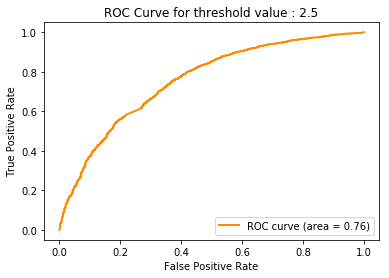

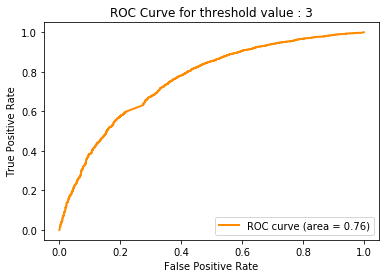

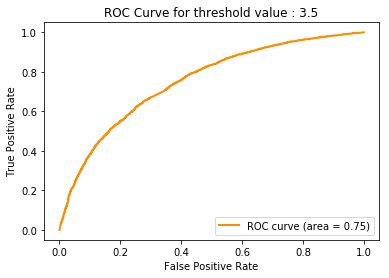

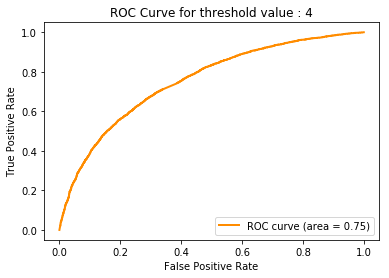

In [195]:
thresholds = [2.5,3,3.5,4]
plot_roc_curves(test_set,preds,thresholds)

In [179]:
y_test = []
y_preds = []
for x in testset:
    if x[2] < 2.5:
        y_test.append(0)
    else:
        y_test.append(1)
for i in range(len(preds)-1):
        y_preds.append(preds[i][3])

In [180]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds)

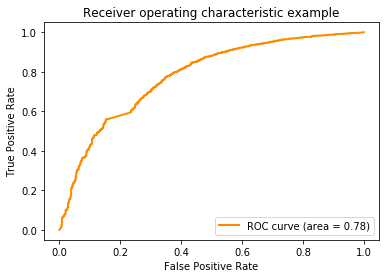

### MF (SVD) Filtering
#### Questions 24-28

In [69]:
from surprise.prediction_algorithms.matrix_factorization import SVD

In [70]:
def SVD_filter(data_, range_,trimm,movie_ratings_dict,splits=10, id_var_dict=None):
    kf = KFold(n_splits=splits)
    reader = Reader(rating_scale=(1, 5))
    mae_d={}
    rmse_d={}
    for latent_factors in range_:
        print('Number of Latent Factors : ',latent_factors)
        svd_model = SVD(n_factors = latent_factors)
        rmse_list=[]
        mae_list =[]
        for trainset, testset in kf.split(data_):
            #print(testset)
            if(trimm=='p'):
                testset = get_popular(movie_ratings_dict,testset)
            elif(trimm=='up'):
                testset = get_unpopular(movie_ratings_dict,testset)
            elif(trimm=='hv'):
                testset = get_highvar(movie_ratings_dict,testset)
            svd_model.fit(trainset)
            predictions = svd_model.test(testset,verbose=False)
            rmse_list.append(accuracy.rmse(predictions,verbose=False))
            mae_list.append(accuracy.mae(predictions,verbose=False))
        rmse_d[latent_factors]=sum(rmse_list)/len(rmse_list)
        mae_d[latent_factors]=sum(mae_list)/len(mae_list)
        print('Mean rmse',sum(rmse_list)/len(rmse_list))
        print('Mean mae',sum(mae_list)/len(mae_list))
    return rmse_d, mae_d


In [71]:
total_data = Dataset.load_from_df(dataset[['userId','movieId','rating']], reader)
svd_rmse , svd_mae = SVD_filter(total_data, range(2,51,2),'notrim',movie_ratings_dict)

Number of Latent Factors :  2
Mean rmse 0.887486178063
Mean mae 0.683750101431
Number of Latent Factors :  4
Mean rmse 0.887180392161
Mean mae 0.683042022178
Number of Latent Factors :  6
Mean rmse 0.886904308602
Mean mae 0.683064118982
Number of Latent Factors :  8
Mean rmse 0.887196916675
Mean mae 0.683352100776
Number of Latent Factors :  10
Mean rmse 0.88743461396
Mean mae 0.682773115803
Number of Latent Factors :  12
Mean rmse 0.887965371781
Mean mae 0.683650840174
Number of Latent Factors :  14
Mean rmse 0.88790671912
Mean mae 0.683665802025
Number of Latent Factors :  16
Mean rmse 0.887199495793
Mean mae 0.682840466164
Number of Latent Factors :  18
Mean rmse 0.887499458704
Mean mae 0.683125655705
Number of Latent Factors :  20
Mean rmse 0.888575888827
Mean mae 0.68444951401
Number of Latent Factors :  22
Mean rmse 0.88899511917
Mean mae 0.684687968034
Number of Latent Factors :  24
Mean rmse 0.887894106718
Mean mae 0.683425366772
Number of Latent Factors :  26
Mean rmse 0.88784

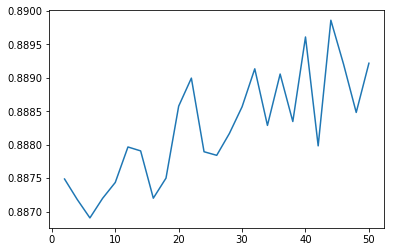

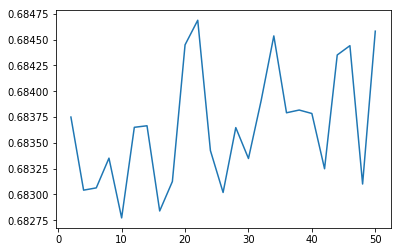

In [79]:
rmse_x = list(svd_rmse.keys())
rmse_y = list(svd_rmse.values())
plt.plot(rmse_x,rmse_y)
plt.show()
mae_x = list(svd_mae.keys())
mae_y = list(svd_mae.values())
plt.plot(mae_x,mae_y)
plt.show()

In [ ]:
#svd_rmse_p , svd_mae_p = SVD_filter(total_data, range(2,51,8),'p',movie_ratings_dict) #replace 8 with 2
#svd_rmse_up , svd_mae_up = SVD_filter(total_data, range(2,51,8),'up',movie_ratings_dict) #replace 8 with 2
#svd_rmse_hv , svd_mae_hv = SVD_filter(total_data, range(2,51,8),'hv',movie_ratings_dict, id_var_dict) #replace 8 with 2